# 勾配ブースティング応用(XGBoost, LightGBM, CatBoost)

## XGBoost(eXtreme Gradient Boosting)
- GBDTに正則化項を加えることで過学習を防ぐ
    - 木が大きくなりすぎないようにする
    - 一つのモデルで残差を大きく減らさないようにする

### データ準備

In [33]:
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
# データ準備
df = sns.load_dataset('titanic')
df.dropna(inplace=True)
# X, yを作成
X = df.drop(['survived', 'alive'], axis=1)
y = df['survived']
# ラベルエンコーディング
oe = OrdinalEncoder()
# oe.set_output(transform='pandas')
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()
X[cat_cols] = oe.fit_transform(X[cat_cols])
# hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


### 実装
-  xgboost.XGBClassifierクラス
    - n_estimators: イテレーションの回数（弱学習器の数）
    - learning_rate: shrinkageパラメータのn
    - eval_metric: early stoppingに使用する評価指標(sklearn.metricsのメソッドを指定)
    - early_stopping_rounds: early stoppingする際の最低限のイテレーション回数
    - impotance_type: デフォルトだと"weight"(頻度)になっているので"total_gain"を指定する
- .fit(X, y)で学習
    - eval_set: 各イテレーション毎に評価したいデータ 例: [(X_val, y_val)]
    - verbose: Trueを指定すると各イテレーションの評価結果をprintする
- .predict(X)で予測
- xgboost.plot_tree(model, num_trees)で任意の木構造を描画(graphvizが必要)

In [13]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.01,
              eval_metric="auc",
              early_stopping_rounds=10,
              importance_type="total_gain",
              random_state=0)

xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)# 本当は検証用データを用いる


[0]	validation_0-auc:0.89904


[1]	validation_0-auc:0.89663
[2]	validation_0-auc:0.89663
[3]	validation_0-auc:0.89663
[4]	validation_0-auc:0.89663
[5]	validation_0-auc:0.89663
[6]	validation_0-auc:0.89103
[7]	validation_0-auc:0.89103
[8]	validation_0-auc:0.88942
[9]	validation_0-auc:0.89103
[10]	validation_0-auc:0.88622


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type='total_gain', interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [14]:
from sklearn.metrics import roc_auc_score
y_pred_xgb = xgb.predict_proba(X_test) # 本当はテストデータを用いる
print(f"xgboost AUC: {roc_auc_score(y_test, y_pred_xgb[:, 1])}")

xgboost AUC: 0.8990384615384616


## Light GBM(Light Gradient Boosted Machine)
XGBoostよりも高速で精度が高くなるケースが多い
- leaf wise
    - 最も損失が小さくなるようなノードから分割する方法で決定木を作ることで高速化
- histogram based
    - データをヒストグラム化し、bin単位で分割する方法で決定木のノードを分割することで高速化
- Gradient-based One-Side Sampling(GOSS)
    - 残差が小さいデータの一部を学習に使わないことで学習データを減らし高速化
- Exclusive Feature Bundling(EFB)
    - 互いに排他的な複数の特徴量を一つにまとめ(bundle化)、それぞれの特徴量の値の範囲が被らないように値をずらし、特徴量数を減らし高速化

### データ準備

In [2]:
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
# データ準備
df = sns.load_dataset('titanic')
df.dropna(inplace=True)
# X, yを作成
X = df.drop(['survived', 'alive'], axis=1)
y = df['survived']
# ラベルエンコーディング
oe = OrdinalEncoder()
# oe.set_output(transform='pandas')
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()
X[cat_cols] = oe.fit_transform(X[cat_cols])
# hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


### 実装
- lightgbm.LGBMClassifierクラス
    - n_estimators: イテレーションの回数(弱学習器の数)
    - learning_rate: shrinkageパラメータのn
    - boosting_type: ブースティングアルゴリズムを指定
        - "gbdt", "dart", "goss", "rf"から選択
    - max_depth: 決定木の最大の深さ
- .fit(X, y)で学習
    - eval_set:各イテレーション毎に評価したいデータ　例: [(X_val, y_val)]
    -callbacks: 各イテレーション時に実行する関数のリスト(early stoppingに使用)
- lgb.plot_metric(model)で学習曲線を描画

In [6]:
# !pip install lightgbm==3.3.1
import lightgbm as lgb
lgbmc = lgb.LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)
# early stoppingに使用する検証データ
eval_set = [(X_test, y_test)]
# イテレーション時に実施(callback)する関数
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=10))
callbacks.append(lgb.log_evaluation())
# 学習
lgbmc.fit(X_train, y_train, eval_set=eval_set, callbacks=callbacks)

[1]	valid_0's binary_logloss: 0.56902
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.536293
[3]	valid_0's binary_logloss: 0.50876
[4]	valid_0's binary_logloss: 0.485108
[5]	valid_0's binary_logloss: 0.464864
[6]	valid_0's binary_logloss: 0.447251
[7]	valid_0's binary_logloss: 0.433086
[8]	valid_0's binary_logloss: 0.41859
[9]	valid_0's binary_logloss: 0.408127
[10]	valid_0's binary_logloss: 0.400311
[11]	valid_0's binary_logloss: 0.400311
[12]	valid_0's binary_logloss: 0.400311
[13]	valid_0's binary_logloss: 0.400311
[14]	valid_0's binary_logloss: 0.400311
[15]	valid_0's binary_logloss: 0.400311
[16]	valid_0's binary_logloss: 0.400311
[17]	valid_0's binary_logloss: 0.400311
[18]	valid_0's binary_logloss: 0.400311
[19]	valid_0's binary_logloss: 0.400311
[20]	valid_0's binary_logloss: 0.400311
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.400311


LGBMClassifier(boosting_type='goss', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [7]:
y_pred_lgbmc = lgbmc.predict_proba(X_test)
print(f"light gbm AUC: {roc_auc_score(y_test, y_pred_lgbmc[:,1])}")

light gbm AUC: 0.9383012820512822


学習曲線を見る。傾斜が急な場合はlearning_rateを下げることを考える。

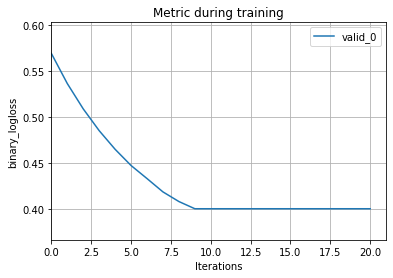

In [5]:
lgb.plot_metric(lgbmc)

## CatBoost(Category Boosting)
XGBoostやLightGBMより後発で、使い勝手が良く高精度が期待できる
- Orderd TS(Orderd Target Statistics)
    - ランダムに順序を決め、過去のデータからTSを算出する
- Ordered Boosting
    - 残差の計算に使うモデルを、推論に使うモデル群と分け、過学習を避ける
- Symmetric Trees
    - 同じ階層では全てのノードで同じ特徴量の同じ条件で分割をする
    - 全てのデータに対して共通の処理を行えるので効率が良い
    - 特に推論の高速化が期待できる

### データ準備

In [20]:
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
# データ準備
df = sns.load_dataset('titanic')
df.dropna(inplace=True)
# X, yを作成
X = df.drop(['survived', 'alive'], axis=1)
y = df['survived']
# ラベルエンコーディング
oe = OrdinalEncoder()
# oe.set_output(transform='pandas')

# カテゴリカル変数名のリストを取得
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()
# X[cat_cols] = oe.fit_transform(X[cat_cols])
# hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


### 実装
- catboost.CatBoostClassifierクラス
    - iterations: イテレーションの回数(弱学習器の数)
    - learning_rate: 学習率
    - cat_features: カテゴリカル変数のカラム名(or index)のリスト
- .fit(X, y)で学習
    - eval_set: 各イテレーション毎に評価したいデータ 例: [(X_val, y_val)]
    - early_stopping_rounds: early stoppingする最の最低限のイテレーション数
- .predict(X)で予測
- .plot_metric(tree_idx) で任意の木構造を描画

In [24]:
from catboost import CatBoostClassifier
import numpy
# cat_colsはデータ準備参照
cbc = CatBoostClassifier(iterations=1000, learning_rate=0.01, cat_features=cat_cols)
eval_set = [(X_test, y_test)] # 本当は検証用データを用いる
cbc.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=10, verbose=True)

0:	learn: 0.6885366	test: 0.6868442	best: 0.6868442 (0)	total: 1.8ms	remaining: 1.8s
1:	learn: 0.6814490	test: 0.6793775	best: 0.6793775 (1)	total: 18.6ms	remaining: 9.29s
2:	learn: 0.6760508	test: 0.6726860	best: 0.6726860 (2)	total: 21.9ms	remaining: 7.29s
3:	learn: 0.6712676	test: 0.6671826	best: 0.6671826 (3)	total: 25.3ms	remaining: 6.3s
4:	learn: 0.6653107	test: 0.6593995	best: 0.6593995 (4)	total: 33.4ms	remaining: 6.65s
5:	learn: 0.6598695	test: 0.6518437	best: 0.6518437 (5)	total: 35.5ms	remaining: 5.87s
6:	learn: 0.6558456	test: 0.6467404	best: 0.6467404 (6)	total: 37.5ms	remaining: 5.32s
7:	learn: 0.6515199	test: 0.6413944	best: 0.6413944 (7)	total: 39.5ms	remaining: 4.9s
8:	learn: 0.6471426	test: 0.6356173	best: 0.6356173 (8)	total: 41.5ms	remaining: 4.57s
9:	learn: 0.6431772	test: 0.6310513	best: 0.6310513 (9)	total: 44.1ms	remaining: 4.36s
10:	learn: 0.6392733	test: 0.6260433	best: 0.6260433 (10)	total: 45.6ms	remaining: 4.1s
11:	learn: 0.6349835	test: 0.6211657	best: 0.6

In [23]:
y_pred_cbc = cbc.predict_proba(X_test) # 本当はテストデータを用いる
print(f"catboost AUC: {roc_auc_score(y_test, y_pred_cbc[:, 1])}")

catboost AUC: 0.8942307692307693
